In [1]:
import numpy as np
import cv2  # OpenCVライブラリ

import matplotlib.pyplot as plt 
%matplotlib inline

import torch

import pickle

import torch.utils.data as data
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function

In [2]:
# import dataset
from utils.dataset import VOCDataset, DatasetTransform, make_datapath_list, Anno_xml2list, od_collate_fn

In [3]:
## meta settings
import pretrainedmodels
model_name = 'resnet18' # choose from any resnets
DATASET = "VOC"
retina = False # for trying retinanets
fpn = False # try for fpns
HALF = False
scale = 1

In [4]:
num_class = 20 # for VOC
batch_size = 32
input_size = 320 # should be dividable with 32
MODEL_SCALE = 4 # output heatmap scale

In [5]:
# set your VOCdevkit path here.
vocpath = "../VOCdevkit/VOC2007"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(vocpath)

image_index = []
for l in val_img_list:
    image_index.append(l[-10:-4])

image_index[0]

'000001'

In [6]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
color_mean = (104, 117, 123)  # (BGR)の色の平均値

## set dataset

In [7]:
# from centernet repo
def draw_msra_gaussian(heatmap, center, sigma=1):
  tmp_size = sigma * 3
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap

In [8]:
# wrap as function
def make_hm(target, input_size=512, num_class=20):
    # make output heatmap for each class
    hm = np.zeros([num_class, input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    # make regr heatmap 
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

    # convert targets to its center.
    center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, \
                         np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4].astype(int)]).T
    regrs = np.asarray([np.asarray([target[:,2]-target[:,0]]), \
                     np.asarray([target[:,3]-target[:,1]])]).T

    # make masks
    for r, c in zip(regrs, center):
        mask = hm[int(c[2]), :, :]
        mask = draw_msra_gaussian(mask, [int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE])
        hm[int(c[2]), :, :] = mask
        regr[:, int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE] = r
    return hm, regr

In [9]:
class centerVOCDataset(data.Dataset):
    def __init__(self, img_list, anno_list, phase, transform, transform_anno, input_size=512):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno
        self.input_size = input_size
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        im, hm, regr = self.pull_item(index)
        #print(im.shape)
        #print(hm.shape)
        #print(regr.shape)
        return im, hm, regr
    
    def pull_item(self, index):
        # 1. read image
        img_path = self.img_list[index]
        img = cv2.imread(img_path)
        height, width, channel = img.shape
        
        # 2. read annotations
        xml_path = self.anno_list[index]
        anno_list = self.transform_anno(xml_path, width, height)
        
        # 3. augumentations
        img, boxes, labels = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, 4])
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        
        # 4. transform BGR to RGB
        img = torch.from_numpy(img[:, :, (2, 1, 0)])
        img = img.permute(2, 0, 1)
        
        # 5. convert boxes inforatmion to heatmaps
        hm, regr = make_hm(gt, self.input_size)
        
        return img, hm, regr

In [10]:
## DatasetTransform
transform = DatasetTransform(input_size)
transform_anno = Anno_xml2list(voc_classes)

# call dataset
train_dataset2 = centerVOCDataset(train_img_list, train_anno_list, phase = "train", transform=transform, transform_anno = transform_anno, input_size=input_size)
val_dataset2 = centerVOCDataset(val_img_list, val_anno_list, phase="val", transform=DatasetTransform(
    input_size), transform_anno=Anno_xml2list(voc_classes), input_size=input_size)

# dataloader
train_dataloader = data.DataLoader(
    train_dataset2, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader = data.DataLoader(
    val_dataset2, batch_size=batch_size, shuffle=False, num_workers=8)

## let's make a binding box from the heatmap!

In [11]:
id = 1
img, hm, regr = val_dataset2[id]
print(hm.shape)
print(regr.shape)

(20, 80, 80)
(2, 80, 80)


In [12]:
# threshold heatmap and get center points
thresh = 0.7

hm = F.sigmoid(torch.from_numpy(hm)).numpy()
print(hm.shape)
where = np.where(hm > thresh)

# center = [xmin,ymin, y, class, score]
# box = xmin, ymin, xmax, ymax, class, score
clss = np.asarray(where[0])
xs = np.asarray(where[1])
ys = np.asarray(where[2])

center = []; box = []
for y,x,cls in zip(xs, ys, clss):
    score = hm[cls,x,y]
    w, h = regr[:, x, y] * input_size//MODEL_SCALE
    print(w)
    print(h)
    
    box.append(np.asarray([x-w/2,y-h/2,x+w/2,y+h/2,cls,score]))
    center.append(np.asarray([x,y,cls,score]))

center = np.asarray(center)
box = np.asarray(box)

# scale box scale to original image
box[:, 0:4] *= MODEL_SCALE
center[:, 0:2] *= MODEL_SCALE

(20, 80, 80)
16.0
16.0


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [13]:
center

array([[164.        , 156.        ,  18.        ,   0.50457878]])

In [14]:
box

array([[132.        , 124.        , 196.        , 188.        ,
         18.        ,   0.50457878]])

plot center points


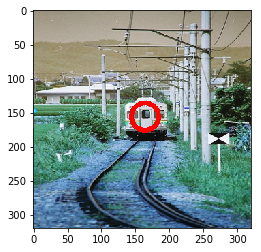

In [15]:
# Let's see if the center is encoded right
img2 = cv2.imread("../VOCdevkit/VOC2007/JPEGImages/00000{}.jpg".format(id+1))
img2 = cv2.resize(img2, (input_size, input_size))

# plot stuff centers
for c in center:
    img2 = cv2.circle(img2, (int(c[0]), int(c[1])), 20, (255, 0, 0), 5)

print("plot center points")
plt.imshow(img2/255)
plt.show()

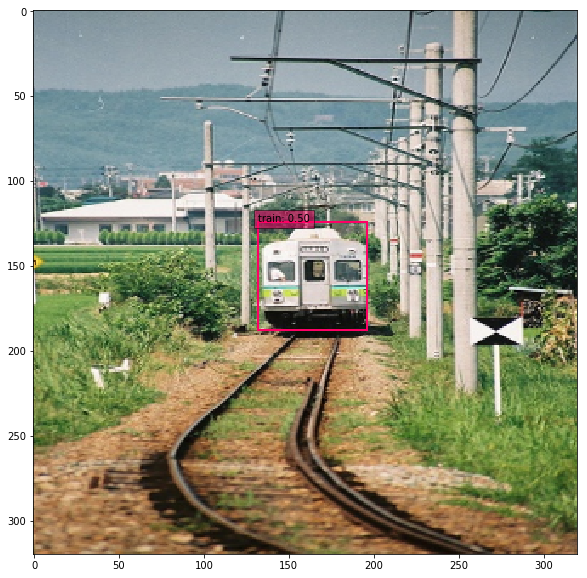

In [16]:
# plot boxes
from utils.ssd_predict_show import vis_bbox
# Let's see if the center is encoded right
img2 = cv2.imread("../VOCdevkit/VOC2007/JPEGImages/00000{}.jpg".format(id+1))
img2 = cv2.resize(img2, (input_size, input_size))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

vis_bbox(img2, box, label_index=box[:,4], scores=box[:,5], label_names=voc_classes)

In [71]:
# wrap to function..
def show_detection(img, hm, regr, thresh=0.5, input_size=256):
    hm = F.sigmoid(torch.from_numpy(hm)).numpy()
    print(hm.shape)
    where = np.where(hm > thresh)
    #print(where)

    # center = [xmin,ymin, y, class, score]
    # box = xmin, ymin, xmax, ymax, class, score
    clss = np.asarray(where[0])
    xs = np.asarray(where[1])
    ys = np.asarray(where[2])

    center = []; box = [];
    for y,x,cls in zip(xs, ys, clss):
        print(y,x,cls)
        score = hm[cls,x,y]
        w, h = regr[:, x, y] * input_size//MODEL_SCALE

        box.append(np.asarray([x-w/2,y-h/2,x+w/2,y+h/2,cls,score]))
        center.append(np.asarray([x,y,cls,score]))
    
    center = np.asarray(center)
    print("center shape:", center.shape)
    box = np.asarray(box)
    print("box shape:", box.shape)
    
    # scale box scale to original image
    box[:,0:4] *= MODEL_SCALE
    center[0:2] *= MODEL_SCALE
    
    print(box)
    
    # Let's see if the center is encoded right
    img2 = cv2.resize(img, (input_size, input_size))
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # plot stuff centers
    for c in center:
        img2 = cv2.circle(img2, (int(c[0]), int(c[1])), 20, (255, 0, 0), 5)

    print("plot center points")
    plt.imshow(img2/255)
    plt.show()
    
    # plot boxes
    from utils.ssd_predict_show import vis_bbox
    # Let's see if the center is encoded right
    img2 = cv2.resize(img, (input_size, input_size))
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    vis_bbox(img2, box, label_index=box[:,4], scores=box[:,5], label_names=voc_classes)

# set up model

In [66]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

In [67]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

# create backbone.
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[:-2])

class centernet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(centernet, self).__init__()
        self.base_model = basemodel
        
        if model_name == "resnet34" or model_name=="resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        
        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        # output classification
        self.outc = nn.Conv2d(256, n_classes, 1)
        # output residue
        self.outr = nn.Conv2d(256, 2, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.base_model(x)
        
        # Add positional info        
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr

In [68]:
# test if net works
model = centernet(num_class) # +2 for width and height regressions
print(torch.rand([1,3,input_size,input_size]).size())
outc, outr = model(torch.rand([1,3,input_size,input_size]))
print(outc.size())
print(outr.size())

torch.Size([1, 3, 320, 320])
torch.Size([1, 20, 80, 80])
torch.Size([1, 2, 80, 80])


In [69]:
# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("used device:", device)

# ネットワークをGPUへ
model.to(device)
model.load_state_dict(torch.load('./weights/VOC_resnet18_320_100.pth'))

used device: cuda:0


<All keys matched successfully>

# infer images

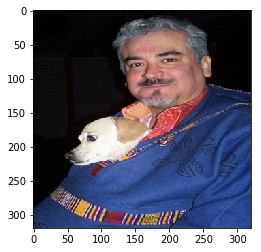

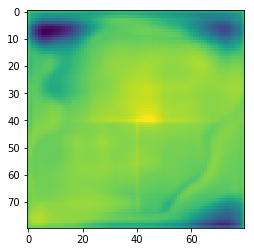

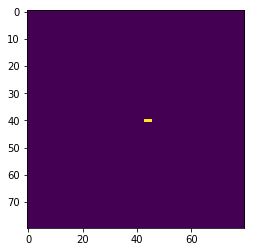

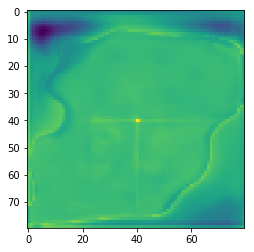

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(20, 80, 80)
48 27 11
48 28 11
40 43 14
40 44 14
40 45 14
center shape: (5, 4)
box shape: (5, 6)
[[1.08000000e+02 1.92000000e+02 1.08000000e+02 1.92000000e+02
  1.10000000e+01 3.40221939e-03]
 [1.12000000e+02 1.92000000e+02 1.12000000e+02 1.92000000e+02
  1.10000000e+01 3.97315295e-03]
 [1.70000000e+02 1.58000000e+02 1.74000000e+02 1.62000000e+02
  1.40000000e+01 2.99138315e-02]
 [1.74000000e+02 1.58000000e+02 1.78000000e+02 1.62000000e+02
  1.40000000e+01 1.92527529e-02]
 [1.78000000e+02 1.58000000e+02 1.82000000e+02 1.62000000e+02
  1.40000000e+01 1.59749296e-02]]
plot center points


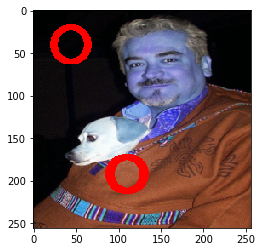

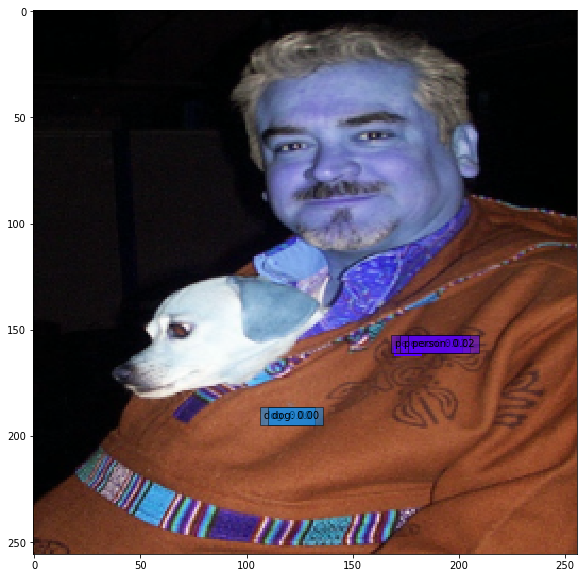

In [76]:
id = 0
img, hm, regr = val_dataset2[id]
img2 = cv2.imread("../VOCdevkit/VOC2007/JPEGImages/00000{}.jpg".format(id+1))
img2 = cv2.resize(img2, (input_size, input_size))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img = img.to(device).unsqueeze(0)
with torch.no_grad():
    hm, regr = model(img)

hm = hm.cpu().numpy();regr = regr.cpu().numpy()

plt.imshow(img2)
plt.show()
plt.imshow(hm[0,14])
plt.show()
plt.imshow(hm[0,14]>0)
plt.show()
plt.imshow(regr[0,0])
plt.show()
show_detection(img2, hm[0], regr[0], thresh=0.5, input_size=256)

In [23]:
for i, imp in enumerate(val_img_list):
    detections, pre_dict_label_index = ssd.ssd_predict2(imp, data_confidence_level=0.05)
    
    for cls in range(21):
        box = []
        for j,pred in enumerate(detections):
            if cls == pre_dict_label_index[j]:
                box.append(pred)
        if not box == []:
            all_boxes[cls][i] = box
        else:
            all_boxes[cls][i] = empty_array
    if i%1000==0:
        print("iter:", i)

NameError: name 'ssd' is not defined

In [ ]:
all_boxes[7][0:10]

# eval accuracy

In [ ]:
# eval function
def voc_eval(detpath,
             annopath,
             imagesetfile,
             classname,
             cachedir,
             ovthresh=0.5,
             use_07_metric=False):
  """
  rec, prec, ap = voc_eval(detpath,
                              annopath,
                              imagesetfile,
                              classname,
                              [ovthresh],
                              [use_07_metric])
  Top level function that does the PASCAL VOC evaluation.
  detpath: Path to detections
      detpath.format(classname) should produce the detection results file.
  annopath: Path to annotations
      annopath.format(imagename) should be the xml annotations file.
  imagesetfile: Text file containing the list of images, one image per line.
  classname: Category name (duh)
  cachedir: Directory for caching the annotations
  [ovthresh]: Overlap threshold (default = 0.5)
  [use_07_metric]: Whether to use VOC07's 11 point AP computation
      (default False)
  """
  # assumes detections are in detpath.format(classname)
  # assumes annotations are in annopath.format(imagename)
  # assumes imagesetfile is a text file with each line an image name
  # cachedir caches the annotations in a pickle file

  # first load gt
  if not os.path.isdir(cachedir):
    os.mkdir(cachedir)
  cachefile = os.path.join(cachedir, '%s_annots.pkl' % imagesetfile)
  # read list of images
  with open(imagesetfile, 'r') as f:
    lines = f.readlines()
  imagenames = [x.strip() for x in lines]

  if not os.path.isfile(cachefile):
    # load annotations
    recs = {}
    for i, imagename in enumerate(imagenames):
      recs[imagename] = parse_rec(annopath.format(imagename))
      #if i % 100 == 0:
        #print('Reading annotation for {:d}/{:d}'.format(
        #  i + 1, len(imagenames)))
    # save
    #print('Saving cached annotations to {:s}'.format(cachefile))
    #with open(cachefile, 'wb') as f:
    #  pickle.dump(recs, f)
  else:
    # load
    with open(cachefile, 'rb') as f:
      try:
        recs = pickle.load(f)
      except:
        recs = pickle.load(f, encoding='bytes')

  # extract gt objects for this class
  class_recs = {}
  npos = 0
  for imagename in imagenames:
    R = [obj for obj in recs[imagename] if obj['name'] == classname]
    bbox = np.array([x['bbox'] for x in R])
    difficult = np.array([x['difficult'] for x in R]).astype(np.bool)
    det = [False] * len(R)
    npos = npos + sum(~difficult)
    class_recs[imagename] = {'bbox': bbox,
                             'difficult': difficult,
                             'det': det}

  # read dets
  detfile = detpath.format(classname)
  with open(detfile, 'r') as f:
    lines = f.readlines()

  splitlines = [x.strip().split(' ') for x in lines]
  image_ids = [x[0] for x in splitlines]
  confidence = np.array([float(x[1]) for x in splitlines])
  BB = np.array([[float(z) for z in x[2:]] for x in splitlines])

  nd = len(image_ids)
  tp = np.zeros(nd)
  fp = np.zeros(nd)

  if BB.shape[0] > 0:
    # sort by confidence
    sorted_ind = np.argsort(-confidence)
#    sorted_scores = np.sort(-confidence)
    BB = BB[sorted_ind, :]
    image_ids = [image_ids[x] for x in sorted_ind]

    # go down dets and mark TPs and FPs
    for d in range(nd):
      id = image_ids[d][-10:-4]
      #print(id)
      # catch bad detections
      try:
          R = class_recs[id]
      except:
        #print("det not found")
        continue
        
      bb = BB[d, :].astype(float)
      ovmax = -np.inf
      BBGT = R['bbox'].astype(float)

      if BBGT.size > 0:
        # compute overlaps
        # intersection
        ixmin = np.maximum(BBGT[:, 0], bb[0])
        iymin = np.maximum(BBGT[:, 1], bb[1])
        ixmax = np.minimum(BBGT[:, 2], bb[2])
        iymax = np.minimum(BBGT[:, 3], bb[3])
        iw = np.maximum(ixmax - ixmin + 1., 0.)
        ih = np.maximum(iymax - iymin + 1., 0.)
        inters = iw * ih

        # union
        uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
               (BBGT[:, 2] - BBGT[:, 0] + 1.) *
               (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)

        overlaps = inters / uni
        ovmax = np.max(overlaps)
        jmax = np.argmax(overlaps)

      if ovmax > ovthresh:
        if not R['difficult'][jmax]:
          if not R['det'][jmax]:
            tp[d] = 1.
            R['det'][jmax] = 1
          else:
            fp[d] = 1.
      else:
        fp[d] = 1.

  # compute precision recall
  fp = np.cumsum(fp)
  tp = np.cumsum(tp)
  rec = tp / float(npos)
  # avoid divide by zero in case the first detection matches a difficult
  # ground truth
  prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
  ap = voc_ap(rec, prec, use_07_metric)

  return rec, prec, ap

In [ ]:
pascal_classes = np.asarray(['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor'])
PASCAL_CLASSES = pascal_classes

# write out detections for evaluation

In [ ]:
import os 
def get_voc_results_file_template(cls):
        # VOCdevkit/results/VOC2007/Main/<comp_id>_det_test_aeroplane.txt
        filename = 'det_' + "val" + '_'+cls+'.txt'
        filedir = os.path.join(DEVKIT_PATH, 'results', 'VOC2007', 'Main')
        if not os.path.exists(filedir):
            os.makedirs(filedir)
        path = os.path.join(filedir, filename)
        return path


def write_voc_results_file(pascal_classes, all_boxes, image_index):
        for cls_ind, cls in enumerate(pascal_classes):
            if cls == '__background__':
                continue
            print('Writing {} VOC results file'.format(cls))
            filename = get_voc_results_file_template(cls)
            with open(filename, 'wt') as f:
                for im_ind, index in enumerate(image_index):
                    dets = np.asarray(all_boxes[cls_ind][im_ind])
                    if dets == []:
                        continue
                    # the VOCdevkit expects 1-based indices
                    for k in range(dets.shape[0]):
                        #print(dets[k, 0])
                        f.write('{:s} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.
                                format(index, dets[k, 0],
                                       dets[k, 1] + 1, dets[k, 2] + 1,
                                       dets[k, 3] + 1, dets[k, 4] + 1))
import xml.etree.ElementTree as ET
def parse_rec(filename):
  """ Parse a PASCAL VOC xml file """
  tree = ET.parse(filename)
  objects = []
  for obj in tree.findall('object'):
    obj_struct = {}
    obj_struct['name'] = obj.find('name').text
    obj_struct['pose'] = obj.find('pose').text
    obj_struct['truncated'] = int(obj.find('truncated').text)
    obj_struct['difficult'] = int(obj.find('difficult').text)
    bbox = obj.find('bndbox')
    obj_struct['bbox'] = [int(bbox.find('xmin').text),
                          int(bbox.find('ymin').text),
                          int(bbox.find('xmax').text),
                          int(bbox.find('ymax').text)]
    objects.append(obj_struct)

  return objects
def voc_ap(rec, prec, use_07_metric=False):
  """ ap = voc_ap(rec, prec, [use_07_metric])
  Compute VOC AP given precision and recall.
  If use_07_metric is true, uses the
  VOC 07 11 point method (default:False).
  """
  if use_07_metric:
    # 11 point metric
    ap = 0.
    for t in np.arange(0., 1.1, 0.1):
      if np.sum(rec >= t) == 0:
        p = 0
      else:
        p = np.max(prec[rec >= t])
      ap = ap + p / 11.
  else:
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
      mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
  return ap

In [ ]:
!rm ../VOCdevkit/results/VOC2007/Main/*

In [ ]:
write_voc_results_file(pascal_classes, all_boxes, val_img_list)

# evaluation

In [ ]:
def python_eval(output_dir='output'):
        annopath = os.path.join(
            DEVKIT_PATH,
            'VOC2007',
            'Annotations',
            '{:s}.xml')
        imagesetfile = os.path.join(
            DEVKIT_PATH,
            'VOC2007',
            'ImageSets',
            'Main',
            SET + '.txt')
        cachedir = os.path.join(DEVKIT_PATH, 'annotations_cache')
        aps = []
        # The PASCAL VOC metric changed in 2010.
        # VOC07 metric is quite old so don't use.
        use_07_metric = False
        print('VOC07 metric? ' + ('Yes' if use_07_metric else 'No'))
        if not os.path.isdir(output_dir):
            os.mkdir(output_dir)
        for i, cls in enumerate(PASCAL_CLASSES):
            if cls == '__background__':
                continue
            filename = get_voc_results_file_template(cls)
            rec, prec, ap = voc_eval(
                filename, annopath, imagesetfile, cls, cachedir, ovthresh=0.5,
                use_07_metric=use_07_metric)
            aps += [ap]
            print('AP for {} = {:.4f}'.format(cls, ap))
            with open(os.path.join(output_dir, cls + '_pr.pkl'), 'wb') as f:
                pickle.dump({'rec': rec, 'prec': prec, 'ap': ap}, f)
        print('Mean AP = {:.4f}'.format(np.mean(aps)))
        print('~~~~~~~~')
        print('Results:')
        for ap in aps:
            print('{:.3f}'.format(ap))
        print('{:.3f}'.format(np.mean(aps)))
        print('~~~~~~~~')
        print('')
        print('--------------------------------------------------------------')
        print('Results computed with the **unofficial** Python eval code.')
        print('Results should be very close to the official MATLAB eval code.')
        print('Recompute with `./tools/reval.py --matlab ...` for your paper.')
        print('-- Thanks, The Management')
        print('--------------------------------------------------------------')

In [ ]:
# evaluate detections
python_eval()